# CMSC 197 
## Naive Baye's Theorem
by Zyrex Djewel Ganit

In [1]:
import numpy as np
import pandas as pd
import os
import re
import email
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [5]:
# Define the DataFrame for storing email data
df = pd.DataFrame(columns=["folder", "file", "message", "label"])
label_path = "C:/Users/Zyrex/Documents/UPV COM-SCI - 4 - 1st SEM/CMSC 197/instructions/MP3-Naive Bayes Spam Filter/trec06p/labels"

In [7]:
# Load labels
df_labels = pd.read_csv(label_path, sep=" ", header=None)
df_labels.columns = ["categories", "filepath"]
df_labels["categories"] = df_labels["categories"].apply(lambda x: 0 if x == "ham" else 1)
df_labels["filepath"] = df_labels["filepath"].apply(lambda x: x.replace("../data/", ""))

folder_path = "C:/Users/Zyrex/Documents/UPV COM-SCI - 4 - 1st SEM/CMSC 197/instructions/MP3-Naive Bayes Spam Filter/trec06p/data"
folders = os.listdir(folder_path)
folders = [folder for folder in folders if folder != '.DS_Store']

## Preprocessing

In [9]:
# define punctuation marks, numbers, escape characters, and tags for removal
number = "0123456789"
symbol = r"!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
tags = re.compile('<.*?>')
esc_char = re.compile(r'\\[a-z][a-z]?[0-9]+')


# load stop words
with open('stop_words.txt', 'r') as file:
    stop_words = file.read().splitlines()

# function to extract the email body and remove headers
def extract_message(email_content):
    """Extract plain text message from the email while removing headers."""
    lines = email_content.splitlines()
    
    message_lines = []
    header_section = True  # initially in the header section
    previous_line_had_colon = False  # track if the previous line was a header line

    for line in lines:
        line = line.strip()  # strip leading and trailing whitespace

        if header_section:
            # check if the line is part of a header (contains colon)
            if ':' in line:
                previous_line_had_colon = True  # This is a header line
                continue  # Skip header lines
            else:
                # check if the line is a continuation of the previous header
                if previous_line_had_colon:
                    if line != '' and not line.startswith(" "):  # still in the header if indented or no colon
                        continue
                    else:
                        header_section = False  # We're now in the body section
                else:
                    # if the previous line wasn't a header
                    if line != '':
                        header_section = False  # body section
                        message_lines.append(line)  # capturing the body
        else:
            
            if line != '':  # skip blank
                message_lines.append(line)

    # join all lines to form the complete message body
    return "\n".join(message_lines).strip()

# remove header for multi line
unwanted_words = ['contenttype', 'textplain', 'contenttransferencoding', 'bit', 'quotedprintable']

# function to clean and process email content
def clean_content(text):
    """Clean the email body content."""
    text = text.lower()  # convert to lowercase
    text = re.sub(tags, '', text)  # remove HTML tags
    text = text.translate(str.maketrans('', '', symbol))  # remove punctuation
    text = text.translate(str.maketrans('', '', number))  # remove numbers
    text = re.sub(esc_char, '', text)  # Remove escape characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # remove URLs
    words = text.split()  # Split text into words
    words = [word for word in words if word not in stop_words and word not in unwanted_words and len(word) > 1]  # remove stop words and short words
    return ' '.join(words)

# function to process emails from a folder and return as DataFrame
def process_emails(folder_path, df_labels):
    """Process all emails from the dataset and return a DataFrame with cleaned messages."""
    data_list = []

    for folder in folders:
        files = os.listdir(f"{folder_path}/{folder}")
        for file in files:
            email_file_path = f"{folder_path}/{folder}/{file}"
            try:
                with open(email_file_path, "r", encoding="ISO-8859-1") as e_mail:  
                    email_content = e_mail.read()
                    # print(email_content)

                    raw_message = extract_message(email_content)
                   
                    cleaned_message = clean_content(raw_message)


                    # print(cleaned_message)

                    # Get the classification (label) for the email
                    classification = df_labels[df_labels['filepath'] == f"{folder}/{file}"]['categories'].values[0]

                    # Append the data to the list
                    data_list.append({
                        "folder": folder,
                        "file": file,
                        "email_message": cleaned_message,
                        "classification": classification
                    })

            except Exception as e:
                print(f"Error processing file {email_file_path}: {e}")

    # convert the list into a DataFrame
    return pd.DataFrame(data_list)

df = process_emails(folder_path, df_labels)
print(df.head())  # display the first few rows of the DataFrame


  folder file                                      email_message  \
0    000  000  mailing list queried weeks ago running set arc...   
1    000  001  luxury watches buy rolex rolex cartier bvlgari...   
2    000  002  academic qualifications prestigious nonacc red...   
3    000  003  greetings verify subscription planfans list ch...   
4    000  004  multipart message mime format dragon charsetis...   

   classification  
0               0  
1               1  
2               1  
3               0  
4               1  


In [11]:
df

,folder,file,email_message,classification
0,000,000,mailing list queried weeks ago running set arc...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgari...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,multipart message mime format dragon charsetis...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures infx pri...,1
37818,126,018,oil sector going crazy weekly gift kkpt thing ...,1
37819,126,019,suffering pain depression heartburn well help ...,1
37820,126,020,prosperous future increased money earning powe...,1


In [13]:
# split dataset into training set for ham, training set for spam, and testing set

# separate the training and testing sets
train_ham = df[(df['classification'] == 0) & (df['folder'].astype(int) <= 70)]
train_spam = df[(df['classification'] == 1) & (df['folder'].astype(int) <= 70)]
test_set = df[df['folder'].astype(int) > 70]

# display the sizes of the datasets
print(f"Training set for ham: {len(train_ham)}")
print(f"Training set for spam: {len(train_spam)}")
print(f"Testing set: {len(test_set)}")

print("Sample Training Set for Ham:")
print(train_ham.head())

print("Sample Training Set for Spam:")
print(train_spam.head())

print("Sample Testing Set:")
print(test_set.head())

# create a combined training DataFrame for ham and spam
train_df = pd.concat([train_ham, train_spam], ignore_index=True)
 
# display the first few rows of the combined training set
print("Combined Training DataFrame:")
print(train_df.head())

# display the sizes of the combined training DataFrame
print(f"Total number of emails in train_df: {len(train_df)}")


Training set for ham: 7523
Training set for spam: 13777
Testing set: 16522
Sample Training Set for Ham:
   folder file                                      email_message  \
0     000  000  mailing list queried weeks ago running set arc...   
3     000  003  greetings verify subscription planfans list ch...   
5     000  005           quiet quiet well straw poll plan running   
6     000  006  working departed totally bell labs recommended...   
10    000  010  greetings mass acknowledgement signed planfans...   

    classification  
0                0  
3                0  
5                0  
6                0  
10               0  
Sample Training Set for Spam:
  folder file                                      email_message  \
1    000  001  luxury watches buy rolex rolex cartier bvlgari...   
2    000  002  academic qualifications prestigious nonacc red...   
4    000  004  multipart message mime format dragon charsetis...   
7    000  007  nbc today body diet beaches magazines 

In [15]:
# combine messages from ham and spam sets
combined_messages = pd.concat([train_ham['email_message'], train_spam['email_message']])

# counter for word occurence using Counter()
word_counts = Counter()

for message in combined_messages:
    # split the message into words
    words = message.split()  
    # update the counts with the words from the message
    word_counts.update(words)  

# create a dataframe from the word counts
word_frequency_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# sort by count in descending order and take the top 10000 words
top_10000_words = word_frequency_df.sort_values(by='count', ascending=False).head(10000)

# display the top 10000 words
print(top_10000_words)

           word  count
6457         px  34320
113167     bb  18352
13366      nbsp  16921
23         will  12899
47408     float  12726
...         ...    ...
128393     helm     26
974     porting     26
44585   recieve     26
8014    ruetten     26
15329     hadnt     26

[10000 rows x 2 columns]


## Creating the feature matrices

In [17]:
# Feature Matrix  

# get the list of top 10000 word
top_words = top_10000_words['word'].tolist()

# create a dictionary to map each word to an index (for faster lookup)
word_to_index = {word: idx for idx, word in enumerate(top_words)}

def create_feature_matrix(email_set, word_to_index, vocab_size=10000):
    """Create a feature matrix for the given email set based on the provided word_to_index."""
    # initialize the matrix with zeros
    feature_matrix = np.zeros((len(email_set), vocab_size), dtype=int)
    
    for i, email in enumerate(email_set):
        # tokenize email into words
        words_in_email = set(email.split())   
        
        # check each word in the email and mark its presence in the matrix
        for word in words_in_email:
            # if the word is in the top 10000, we get the index of the word
            if word in word_to_index:  
                index = word_to_index[word]  
                feature_matrix[i, index] = 1  # mark the word's presence
    
    return feature_matrix

# create the feature matrix for ham and spam training sets
ham_feature_matrix = create_feature_matrix(train_ham['email_message'], word_to_index)
spam_feature_matrix = create_feature_matrix(train_spam['email_message'], word_to_index)

# print the dimensions of the generated matrices
print("Ham Feature Matrix shape:", ham_feature_matrix.shape)
print("Spam Feature Matrix shape:", spam_feature_matrix.shape)


Ham Feature Matrix shape: (7523, 10000)
Spam Feature Matrix shape: (13777, 10000)


In [19]:
ham_feature_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [21]:
spam_feature_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Computing the Priors

In [23]:
# Computing the Priors
# compute the prior probabilities for ham and spam

def compute_priors(df):
    # total number of emails in the training set
    n_doc = len(train_df)
    
    # number of ham and spam emails
    n_ham = len(train_ham)
    n_spam = len(train_spam)
    
    # prior probabilities
    p_ham = n_ham / n_doc
    p_spam = n_spam / n_doc
    
    return p_ham, p_spam

p_ham, p_spam = compute_priors(df)
print(f"Prior Probability of Ham: {p_ham}")
print(f"Prior Probability of Spam: {p_spam}")


Prior Probability of Ham: 0.3531924882629108
Prior Probability of Spam: 0.6468075117370892


In [25]:
def compute_word_likelihood(train_df, param, min_count):
    ham_word_count = defaultdict(int)
    spam_word_count = defaultdict(int)
    total_ham_words = 0
    total_spam_words = 0 

    for index, row in train_df.iterrows():
        # split the email message into words
        words = row['email_message'].split()  
        # ham
        if row['classification'] == 0:  
            for word in words:
                ham_word_count[word] += 1
                total_ham_words += 1
        # spam      
        else:  
            for word in words:
                spam_word_count[word] += 1
                total_spam_words += 1

    # Filter words based on minimum count
    filtered_ham_word_count = {word: count for word, count in ham_word_count.items() if count > min_count}
    filtered_spam_word_count = {word: count for word, count in spam_word_count.items() if count > min_count}

    # calculate vocabulary size (distinct words in both ham and spam)
    vocabulary_size = len(set(ham_word_count.keys()).union(set(spam_word_count.keys())))

    word_likelihoods = {
        'ham': {},
        'spam': {}
    }
    
    # Calculate likelihood for ham and spam using Laplace smoothing
    
    for word in filtered_ham_word_count:
        word_likelihoods['ham'][word] = (filtered_ham_word_count[word] + param) / (total_ham_words + (param * vocabulary_size))

    for word in filtered_spam_word_count:
        word_likelihoods['spam'][word] = (filtered_spam_word_count[word] + param) / (total_spam_words + (param * vocabulary_size))
    
    return word_likelihoods, total_ham_words, total_spam_words, vocabulary_size 

word_likelihood, total_ham_words, total_spam_words, vocabulary_size = compute_word_likelihood(train_df, 1, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood['ham'].values())[:10])
print("Spam:\n", list(word_likelihood['spam'].values())[:10])


Word likelihoods for ham and spam: 
Ham:
 [0.0005197453875963078, 0.0032638933148534974, 0.00021274552134771147, 0.00033303201864979306, 0.0008473914436803359, 0.0013240491307505249, 0.0001696578208215927, 0.0004093331549981284, 0.00010861691174292442, 0.003064612699920198]
Spam:
 [9.132956689347906e-05, 0.00046942120046648334, 0.00023822327588299085, 0.0004796398932657537, 0.00018202046548700373, 0.00017435644588755094, 9.771624989302306e-05, 0.00015902840668864538, 0.00015775107008873657, 0.00015775107008873657]


## Classifying the emails

In [28]:

def classify_email(email, word_likelihoods, p_ham, p_spam, total_ham_words, total_spam_words, vocabulary_size):
    words = email.split()

    log_p_ham = np.log(p_ham)
    log_p_spam = np.log(p_spam)

    for word in words:
        if word in word_likelihoods['ham']:
            log_p_ham += np.log(word_likelihoods['ham'][word])
        else:
            log_p_ham += np.log(1 / (total_ham_words + vocabulary_size))

        if word in word_likelihoods['spam']:
            log_p_spam += np.log(word_likelihoods['spam'][word])
        else:
            log_p_spam += np.log(1 / (total_spam_words + vocabulary_size))
            
    if log_p_ham > log_p_spam:
        return 0   # classify as ham
    else:
        return 1   # classify as spam
        

## Testing the Classifier

In [30]:
predictions = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction = classify_email(email, word_likelihood, p_ham, p_spam, total_ham_words, total_spam_words, vocabulary_size)
    predictions.append(prediction)

test_set['predicted_class'] = predictions

print("Test Set with Predictions:")
print(test_set[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


C:\Users\Zyrex\AppData\Local\Temp\ipykernel_1672\489971664.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predicted_class'] = predictions


In [32]:
test_set

,folder,file,email_message,classification,predicted_class
21300,071,000,charsetusascii hesitantly derive perverse sati...,1,1
21301,071,001,things perform experiment display will remain ...,0,0
21302,071,002,best offer month viggra ci ialis vaiium xa naa...,1,1
21303,071,003,multipart message mime format nextpartcf chars...,1,1
21304,071,004,multipart message mime format nextpartcddeb ch...,1,1
...,...,...,...,...,...
37817,126,017,great news expec ted infinex ventures infx pri...,1,1
37818,126,018,oil sector going crazy weekly gift kkpt thing ...,1,1
37819,126,019,suffering pain depression heartburn well help ...,1,1
37820,126,020,prosperous future increased money earning powe...,1,1


In [36]:
# calculate the number of correct predictions
correct_predictions = (test_set['classification'] == test_set['predicted_class']).sum()
total_predictions = len(test_set)
calculated_accuracy = correct_predictions/total_predictions

print(f"Number of correct predictions: {correct_predictions} out of {total_predictions}")
print(f"Accuracy: {calculated_accuracy:.2%}")


Number of correct predictions: 15414 out of 16522
Accuracy: 93.29%


## Performance Evaluation

In [38]:
# Performance Evaluation
# true_label =

tp = 0
tn = 0
fp = 0
fn = 0

for index, row in test_set.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy = (tn + tp) / (tn + tp + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9329379009805109.

Recall: The percentage of spam emails that are correctly classified as spam is 0.9218679838347553.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9773398076739979.



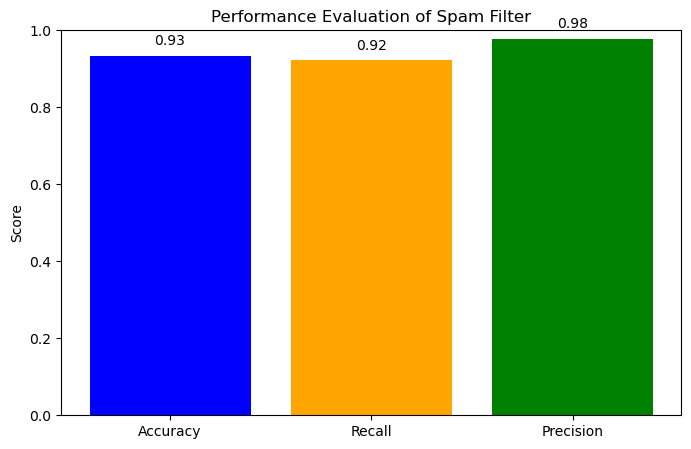

In [40]:
metrics = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Performance Evaluation of Spam Filter')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()



In [42]:
# when stop words are retained
stop_words = ''
df_2 = process_emails(folder_path, df_labels)


In [44]:
df_2

,folder,file,email_message,classification
0,000,000,the mailing list queried about few weeks ago i...,0
1,000,001,luxury watches buy your own rolex for only rol...,1
2,000,002,academic qualifications available from prestig...,1
3,000,003,greetings all this is to verify your subscript...,0
4,000,004,this is multipart message in mime format drago...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures inc infx...,1
37818,126,018,the oil sector is going crazy this is our week...,1
37819,126,019,suffering from pain depression or heartburn we...,1
37820,126,020,do you want for prosperous future increased mo...,1


In [46]:
# split dataset into training set for ham, training set for spam, and testing set

# separate the training and testing sets
train_ham2 = df_2[(df_2['classification'] == 0) & (df_2['folder'].astype(int) <= 70)]
train_spam2 = df_2[(df_2['classification'] == 1) & (df_2['folder'].astype(int) <= 70)]
test_set2 = df_2[df_2['folder'].astype(int) > 70]

# display the sizes of the datasets
print(f"Training set for ham: {len(train_ham2)}")
print(f"Training set for spam: {len(train_spam2)}")
print(f"Testing set: {len(test_set2)}")

# create a combined training DataFrame for ham and spam
train_df2 = pd.concat([train_ham2, train_spam2], ignore_index=True)
 
# display the first few rows of the combined training set
print("Combined Training DataFrame:")
print(train_df2.head())

# display the sizes of the combined training DataFrame
print(f"Total number of emails in train_df: {len(train_df2)}")


Training set for ham: 7523
Training set for spam: 13777
Testing set: 16522
Combined Training DataFrame:
  folder file                                      email_message  \
0    000  000  the mailing list queried about few weeks ago i...   
1    000  003  greetings all this is to verify your subscript...   
2    000  005  its quiet too quiet well how about straw poll ...   
3    000  006  its working here have departed almost totally ...   
4    000  010  greetings all this is mass acknowledgement to ...   

   classification  
0               0  
1               0  
2               0  
3               0  
4               0  
Total number of emails in train_df: 21300


In [48]:
# combine messages from ham and spam sets
combined_messages2 = pd.concat([train_ham2['email_message'], train_spam2['email_message']])

# counter for word occurence using Counter()
word_counts = Counter()

for message in combined_messages:
    # split the message into words
    words = message.split()  
    # update the counts with the words from the message
    word_counts.update(words)  

# create a dataframe from the word counts
word_frequency_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# sort by count in descending order and take the top 10000 words
top_10000_words = word_frequency_df.sort_values(by='count', ascending=False).head(10000)

# display the top 10000 words
print(top_10000_words)

           word  count
6457         px  34320
113167     bb  18352
13366      nbsp  16921
23         will  12899
47408     float  12726
...         ...    ...
128393     helm     26
974     porting     26
44585   recieve     26
8014    ruetten     26
15329     hadnt     26

[10000 rows x 2 columns]


In [50]:
p_ham2, p_spam2 = compute_priors(df_2)
print(f"Prior Probability of Ham: {p_ham2}")
print(f"Prior Probability of Spam: {p_spam2}")

Prior Probability of Ham: 0.3531924882629108
Prior Probability of Spam: 0.6468075117370892


In [54]:
word_likelihood2, total_ham_words2, total_spam_words2, vocabulary_size2 = compute_word_likelihood(train_df2, 1, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood2['ham'].values())[:10])
print("Spam:\n", list(word_likelihood2['spam'].values())[:10])

Word likelihoods for ham and spam: 
Ham:
 [0.04722283139616021, 0.00028858230825973405, 0.0018122370860663092, 0.0022069817978827328, 0.0004311290097489982, 0.00011812436452082379, 0.00018491197990390558, 0.012150361849319165, 0.0009459917462469348, 0.001602902769193963]
Spam:
 [6.443473167214888e-05, 0.0003311855089442617, 0.00016807101338259811, 0.004954715450817825, 0.0003181183255981616, 0.0003383949894110756, 0.0053228495471545085, 0.0011746947235614833, 0.00012841887081512188, 0.00012301176046501148]


In [55]:
# Testing the Classifier
predictions2 = []

for index, row in test_set.iterrows():
    email2 = row['email_message']
    prediction2 = classify_email(email2, word_likelihood2, p_ham2, p_spam2, total_ham_words2, total_spam_words2, vocabulary_size2)
    predictions2.append(prediction2)

test_set2['predicted_class'] = predictions2
# print(predictions2)

print("Test Set with Predictions:")
print(test_set2[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii where we can hesitantly derive ...               1   
21301  there are several things you can use to perfor...               0   
21302  best offer of the month viggra ci ialis vaiium...               1   
21303  this is multipart message in mime format nextp...               1   
21304  this is multipart message in mime format nextp...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


C:\Users\Zyrex\AppData\Local\Temp\ipykernel_1672\2850990977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set2['predicted_class'] = predictions2


In [58]:
# Performance Evaluation
# true_label =

tp = 0
tn = 0
fp = 0
fn = 0

for index, row in test_set2.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy2 = (tn + tp) / (tn + tp + fp + fn)
recall2 = tp / (tp + fn)
precision2 = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy2}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall2}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision2}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.950853407577775.

Recall: The percentage of spam emails that are correctly classified as spam is 0.953480017961383.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9730547154248007.



### 1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results

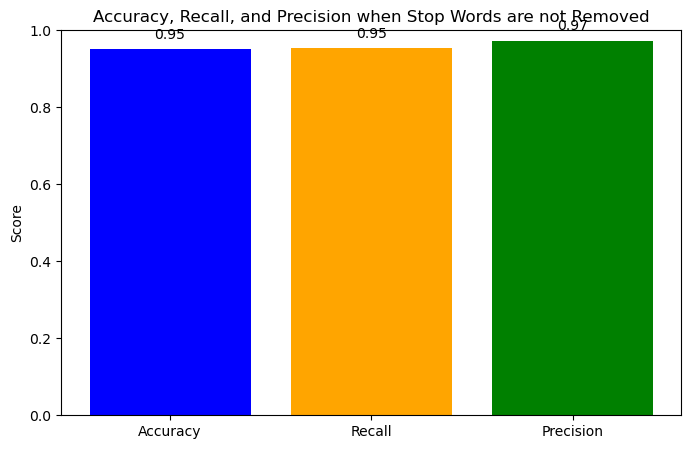

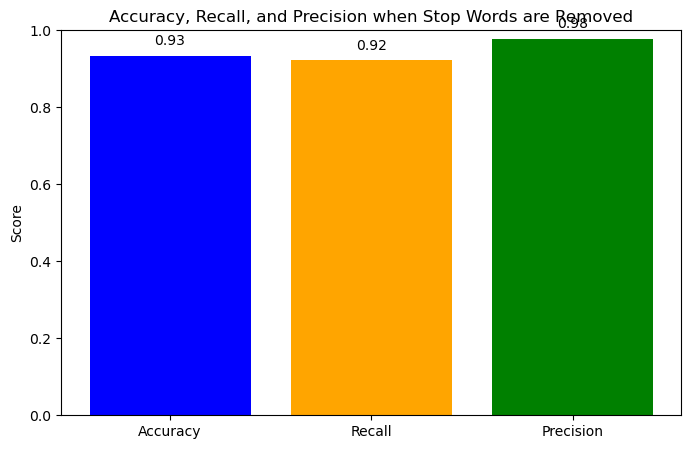

In [66]:

# wehn stop words are removed
metrics = {
    'Accuracy': accuracy2,
    'Recall': recall2,
    'Precision': precision2
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Accuracy, Recall, and Precision when Stop Words are not Removed')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()
print("\n")

# 1. What is the effect of removing stop words in terms of precision, recall, and
# accuracy? Show a plot or a table of these results

# wehn stop words are removed
metrics = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Accuracy, Recall, and Precision when Stop Words are Removed')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()



In [68]:
 # The bar graph of the two datasets shows small differences in terms of its heights and score.
 # When stop words are removed, the scores of accuracy, recall, and precisions decreases.
 # In the current dataset or files provided for training the data, removing the stop words would not
 # have a signifcant or big changes on the scores as seen in the graph 
 # Removing the stop word causes accuracy to decrease from 95% to 93% and recall from 95% to 92%.
 # However, notice that precision increases when removing stop word, it went from 97% to 98%. 

## 2. Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.


In [76]:
 
# Experimenting with different values of k
# k = 1000
word_likelihood_k, total_ham_words_k, total_spam_words_k, vocabulary_size_k = compute_word_likelihood(train_df, 1, 100)
print(f"Word likelihoods for ham and spam with k = {k}:")
print("Ham:\n", list(word_likelihood['ham'].values())[:10])
print("Spam:\n", list(word_likelihood['spam'].values())[:10])
print("Vocabulary Size:", vocabulary_size)
print()



Word likelihoods for ham and spam with k = 1000:
Ham:
 [0.0005197453875963078, 0.0032638933148534974, 0.00021274552134771147, 0.00033303201864979306, 0.0008473914436803359, 0.0013240491307505249, 0.0001696578208215927, 0.0004093331549981284, 0.00010861691174292442, 0.003064612699920198]
Spam:
 [9.132956689347906e-05, 0.00046942120046648334, 0.00023822327588299085, 0.0004796398932657537, 0.00018202046548700373, 0.00017435644588755094, 9.771624989302306e-05, 0.00015902840668864538, 0.00015775107008873657, 0.00015775107008873657]
Vocabulary Size: 159250



In [78]:
test_set_k = test_set.copy()
# Testing the Classifier
predictions_k = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_k = classify_email(email, word_likelihood_k, p_ham, p_spam, total_ham_words_k, total_spam_words_k, vocabulary_size_k)
    predictions_k.append(prediction_k)

test_set_k['predicted_class'] = predictions_k

print("Test Set with Predictions:")
print(test_set_k[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                0  
21303                1  
21304                1  


In [80]:
for index, row in test_set_k.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_k = (tn + tp) / (tn + tp + fp + fn)
recall_k = tp / (tp + fn)
precision_k = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_k}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_k}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_k}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9154158092240648.

Recall: The percentage of spam emails that are correctly classified as spam is 0.8999550965424338.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9724877480712311.



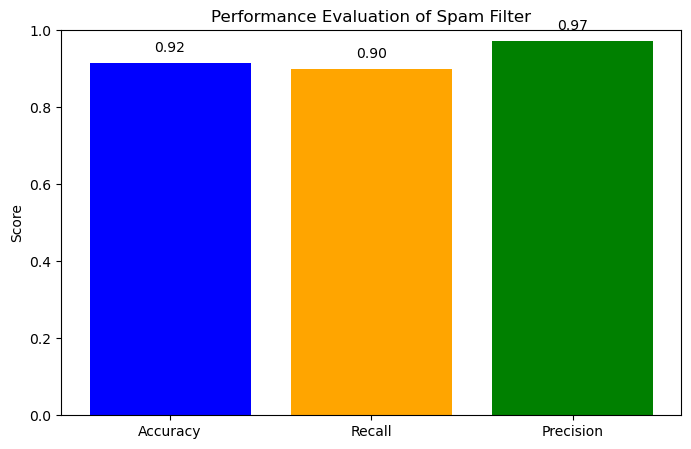

In [82]:
metrics = {
    'Accuracy': accuracy_k,
    'Recall': recall_k,
    'Precision': precision_k
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Performance Evaluation of Spam Filter')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()



In [84]:
test_set_k = test_set.copy()
# Testing the Classifier
predictions_k = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_k = classify_email(email, word_likelihood_k, p_ham, p_spam, total_ham_words_k, total_spam_words_k, vocabulary_size_k)
    predictions_k.append(prediction_k)

test_set_k['predicted_class'] = predictions_k

print("Test Set with Predictions:")
print(test_set_k[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                0  
21303                1  
21304                1  


In [86]:
#  k = 100
word_likelihood_k, total_ham_words_k, total_spam_words_k, vocabulary_size_k = compute_word_likelihood(train_df, 1, 100)
print(f"Word likelihoods for ham and spam with k = {k}:")
print("Ham:\n", list(word_likelihood['ham'].values())[:10])
print("Spam:\n", list(word_likelihood['spam'].values())[:10])
print("Vocabulary Size:", vocabulary_size)
print()



Word likelihoods for ham and spam with k = 1000:
Ham:
 [0.0005197453875963078, 0.0032638933148534974, 0.00021274552134771147, 0.00033303201864979306, 0.0008473914436803359, 0.0013240491307505249, 0.0001696578208215927, 0.0004093331549981284, 0.00010861691174292442, 0.003064612699920198]
Spam:
 [9.132956689347906e-05, 0.00046942120046648334, 0.00023822327588299085, 0.0004796398932657537, 0.00018202046548700373, 0.00017435644588755094, 9.771624989302306e-05, 0.00015902840668864538, 0.00015775107008873657, 0.00015775107008873657]
Vocabulary Size: 159250



In [88]:
test_set_k = test_set.copy()
# Testing the Classifier
predictions_k = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_k = classify_email(email, word_likelihood_k, p_ham, p_spam, total_ham_words_k, total_spam_words_k, vocabulary_size_k)
    predictions_k.append(prediction_k)

test_set_k['predicted_class'] = predictions_k

print("Test Set with Predictions:")
print(test_set_k[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                0  
21303                1  
21304                1  


In [90]:
# calculate the number of correct predictions
correct_predictions_k = (test_set_k['classification'] == test_set_k['predicted_class']).sum()
total_predictions_k = len(test_set_k)
calculated_accuracy_k = correct_predictions_k/total_predictions_k

print(f"Number of correct predictions: {correct_predictions_k} out of {total_predictions_k}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 14539 out of 16522
Accuracy: 93.29%


In [92]:
for index, row in test_set_k.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_k = (tn + tp) / (tn + tp + fp + fn)
recall_k = tp / (tp + fn)
precision_k = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_k}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_k}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_k}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9036032764394948.

Recall: The percentage of spam emails that are correctly classified as spam is 0.8821134560694507.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9722836308443594.



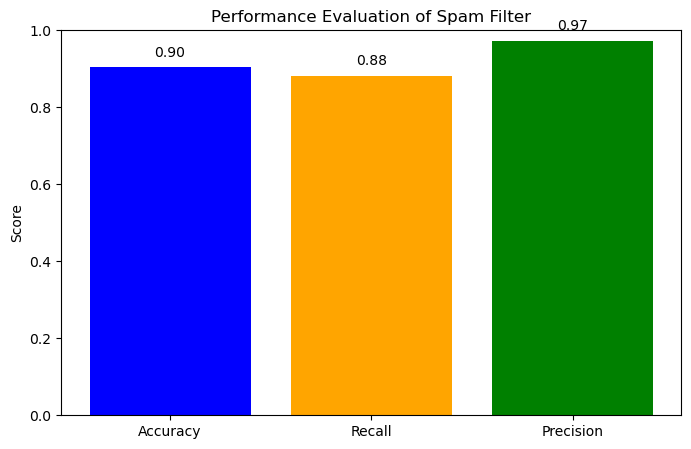

In [94]:
metrics = {
    'Accuracy': accuracy_k,
    'Recall': recall_k,
    'Precision': precision_k
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Performance Evaluation of Spam Filter')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()



In [96]:
#  k = 50
word_likelihood_k, total_ham_words_k, total_spam_words_k, vocabulary_size_k = compute_word_likelihood(train_df, 1, 50)
print(f"Word likelihoods for ham and spam with k = {k}:")
print("Ham:\n", list(word_likelihood['ham'].values())[:10])
print("Spam:\n", list(word_likelihood['spam'].values())[:10])
print("Vocabulary Size:", vocabulary_size)
print()



Word likelihoods for ham and spam with k = 1000:
Ham:
 [0.0005197453875963078, 0.0032638933148534974, 0.00021274552134771147, 0.00033303201864979306, 0.0008473914436803359, 0.0013240491307505249, 0.0001696578208215927, 0.0004093331549981284, 0.00010861691174292442, 0.003064612699920198]
Spam:
 [9.132956689347906e-05, 0.00046942120046648334, 0.00023822327588299085, 0.0004796398932657537, 0.00018202046548700373, 0.00017435644588755094, 9.771624989302306e-05, 0.00015902840668864538, 0.00015775107008873657, 0.00015775107008873657]
Vocabulary Size: 159250



In [98]:
test_set_k = test_set.copy()
# Testing the Classifier
predictions_k = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_k = classify_email(email, word_likelihood_k, p_ham, p_spam, total_ham_words_k, total_spam_words_k, vocabulary_size_k)
    predictions_k.append(prediction_k)

test_set_k['predicted_class'] = predictions_k

print("Test Set with Predictions:")
print(test_set_k[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                0  
21303                1  
21304                1  


In [100]:
# calculate the number of correct predictions
correct_predictions_k = (test_set_k['classification'] == test_set_k['predicted_class']).sum()
total_predictions_k = len(test_set_k)
calculated_accuracy_k = correct_predictions_k/total_predictions_k

print(f"Number of correct predictions: {correct_predictions_k} out of {total_predictions_k}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 14720 out of 16522
Accuracy: 93.29%


In [102]:
for index, row in test_set_k.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_k = (tn + tp) / (tn + tp + fp + fn)
recall_k = tp / (tp + fn)
precision_k = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_k}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_k}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_k}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9004357825929065.

Recall: The percentage of spam emails that are correctly classified as spam is 0.8769420745397396.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9726330992579312.



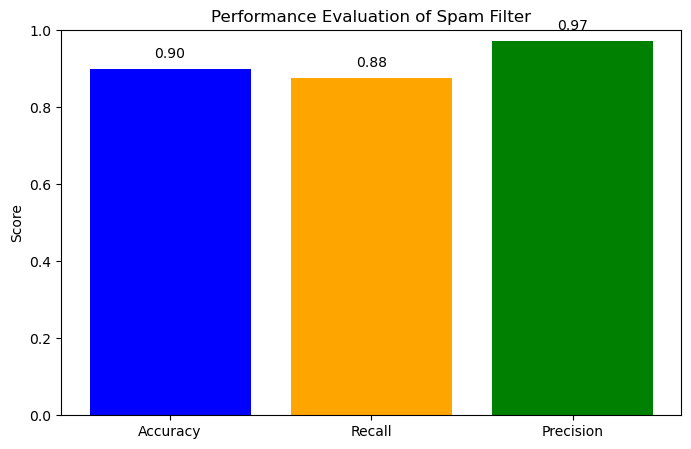

In [104]:
metrics = {
    'Accuracy': accuracy_k,
    'Recall': recall_k,
    'Precision': precision_k
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Performance Evaluation of Spam Filter')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()



In [106]:
# Decreasing the minimum k will change the performance 
# Changing from k = 1000 to k = 100, we saw a sudden drop in the acuracy and recall
# However, when setting k = 50, the performance becomes higher again
# This implies that decreasing the minimum presence of occuring words can greatly affect the performance scores


## 3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

In [108]:
# gamma param = 0.005
word_likelihood_g, total_ham_words_g, total_spam_words_g, vocabulary_size_g = compute_word_likelihood(train_df, 0.005, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood_g['ham'].values())[:10])
print("Spam:\n", list(word_likelihood_g['spam'].values())[:10])

Word likelihoods for ham and spam: 
Ham:
 [0.0006048904129623336, 0.003804084178458919, 0.00024698257266143984, 0.0003872154691536029, 0.0009868680787805389, 0.0015425670939845583, 0.00019674989332096353, 0.00047616917215236303, 0.00012558693092195542, 0.003571758036509216]
Spam:
 [0.00010090568546211667, 0.0005215680973037636, 0.0002643387170897835, 0.0005329373516778621, 0.00020180781803224142, 0.00019328087725166751, 0.00010801146944592826, 0.00017622699569051965, 0.00017480583889375735, 0.00017480583889375735]


In [110]:
# print(word_likelihood

In [112]:
# Testing the Classifier
test_set_g = test_set.copy()
predictions_g = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_g = classify_email(email, word_likelihood_g, p_ham, p_spam, total_ham_words_g, total_spam_words_g, vocabulary_size_g)
    predictions_g.append(prediction_g)

# print(predictions3)

test_set_g['predicted_class'] = predictions_g
# print(predictions2)

print("Test Set with Predictions:")
print(test_set_g[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


In [114]:
# calculate the number of correct predictions
correct_predictions_g = (test_set_g['classification'] == test_set_g['predicted_class']).sum()
total_predictions_g = len(test_set_g)
calculated_accuracy_g = correct_predictions_g/total_predictions_g

print(f"Number of correct predictions: {correct_predictions_g} out of {total_predictions_g}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 15383 out of 16522
Accuracy: 93.29%


In [116]:
# Performance Evaluation

for index, row in test_set_g.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_g = (tn + tp) / (tn + tp + fp + fn)
recall_g = tp / (tp + fn)
precision_g = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_g}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_g}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_g}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9065609490376467.

Recall: The percentage of spam emails that are correctly classified as spam is 0.8852986079928155.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9736675753624906.



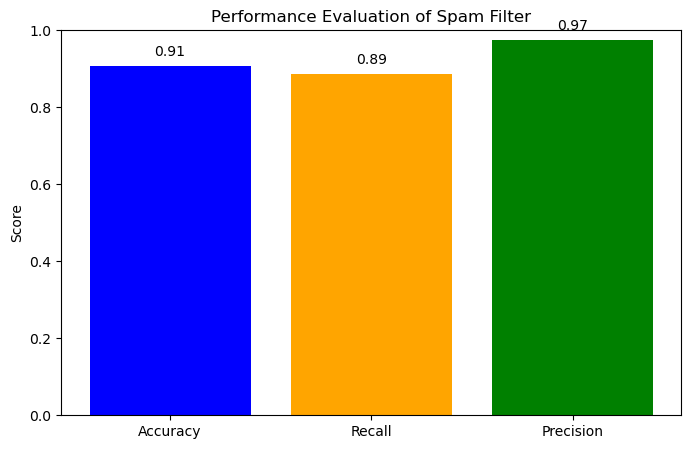

In [117]:
metrics = {
    'Accuracy': accuracy_g,
    'Recall': recall_g,
    'Precision': precision_g
}

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  
plt.ylabel('Score')
plt.title('Performance Evaluation of Spam Filter')

# add value labels on top of the bars
for index, value in enumerate(metrics.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()



In [120]:
# 3. Discuss the results of the different parameters used for Lambda smoothing. 
# Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), 
# Evaluate performance metrics for each.

# gamma param = 0.1
word_likelihood_g, total_ham_words_g, total_spam_words_g, vocabulary_size_g = compute_word_likelihood(train_df, 0.1, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood_g['ham'].values())[:10])
print("Spam:\n", list(word_likelihood_g['spam'].values())[:10])

Word likelihoods for ham and spam: 
Ham:
 [0.0005955606470502183, 0.0037448927661170184, 0.0002432310478611945, 0.0003812783177188822, 0.0009715849268864572, 0.0015186229887852046, 0.0001937812795539631, 0.00046884561576293783, 0.00012372744111871858, 0.0035161875876960733]
Spam:
 [9.989925711790994e-05, 0.0005160875767083582, 0.00026159404344528006, 0.0005273359096702622, 0.000199728212154808, 0.00019129196243338002, 0.00010692946521909994, 0.00017441946299052397, 0.00017301342137028599, 0.00017301342137028599]


In [121]:
# Testing the Classifier
test_set_g = test_set.copy()
predictions_g = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_g = classify_email(email, word_likelihood_g, p_ham, p_spam, total_ham_words_g, total_spam_words_g, vocabulary_size_g)
    predictions_g.append(prediction_g)

# print(predictions3)

test_set_g['predicted_class'] = predictions_g
# print(predictions2)

print("Test Set with Predictions:")
print(test_set_g[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


In [122]:
# calculate the number of correct predictions
correct_predictions_g = (test_set_g['classification'] == test_set_g['predicted_class']).sum()
total_predictions_g = len(test_set_g)
calculated_accuracy_g = correct_predictions_g/total_predictions_g

print(f"Number of correct predictions: {correct_predictions_g} out of {total_predictions_g}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 15382 out of 16522
Accuracy: 93.29%


In [123]:
# Performance Evaluation

for index, row in test_set_g.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_g = (tn + tp) / (tn + tp + fp + fn)
recall_g = tp / (tp + fn)
precision_g = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_g}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_g}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_g}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9106343057741193.

Recall: The percentage of spam emails that are correctly classified as spam is 0.890869630294866.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9743316908671239.



In [125]:
# 3. Discuss the results of the different parameters used for Lambda smoothing. 
# Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), 
# Evaluate performance metrics for each.

# gamma param = 0.5
word_likelihood_g, total_ham_words_g, total_spam_words_g, vocabulary_size_g = compute_word_likelihood(train_df, 0.5, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood_g['ham'].values())[:10])
print("Spam:\n", list(word_likelihood_g['spam'].values())[:10])

Word likelihoods for ham and spam: 
Ham:
 [0.0005592711396756711, 0.0035146589944527263, 0.0002286389360990427, 0.0003581848872080141, 0.0009121388423232422, 0.0014254888426132705, 0.00018223441629881416, 0.00044035955768758543, 0.00011649467991515707, 0.003300038090376669]
Spam:
 [9.588643815863048e-05, 0.0004942357110702744, 0.0002506505137830867, 0.0005050019076354539, 0.0001914364326745991, 0.00018336178525071444, 0.00010261531101186771, 0.00016721249040294508, 0.00016586671583229765, 0.00016586671583229765]


In [126]:
# Testing the Classifier
test_set_g = test_set.copy()
predictions_g = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_g = classify_email(email, word_likelihood_g, p_ham, p_spam, total_ham_words_g, total_spam_words_g, vocabulary_size_g)
    predictions_g.append(prediction_g)

# print(predictions3)

test_set_g['predicted_class'] = predictions_g
# print(predictions2)

print("Test Set with Predictions:")
print(test_set_g[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


In [127]:
# calculate the number of correct predictions
correct_predictions_g = (test_set_g['classification'] == test_set_g['predicted_class']).sum()
total_predictions_g = len(test_set_g)
calculated_accuracy_g = correct_predictions_g/total_predictions_g

print(f"Number of correct predictions: {correct_predictions_g} out of {total_predictions_g}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 15398 out of 16522
Accuracy: 93.29%


In [128]:
# Performance Evaluation

for index, row in test_set_g.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_g = (tn + tp) / (tn + tp + fp + fn)
recall_g = tp / (tp + fn)
precision_g = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_g}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_g}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_g}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9136821899804589.

Recall: The percentage of spam emails that are correctly classified as spam is 0.8950798640066714.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9747806404739283.



In [129]:
# 3. Discuss the results of the different parameters used for Lambda smoothing. 
# Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), 
# Evaluate performance metrics for each.

# gamma param = 1
word_likelihood_g, total_ham_words_g, total_spam_words_g, vocabulary_size_g = compute_word_likelihood(train_df, 1, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood_g['ham'].values())[:10])
print("Spam:\n", list(word_likelihood_g['spam'].values())[:10])

Word likelihoods for ham and spam: 
Ham:
 [0.0005197453875963078, 0.0032638933148534974, 0.00021274552134771147, 0.00033303201864979306, 0.0008473914436803359, 0.0013240491307505249, 0.0001696578208215927, 0.0004093331549981284, 0.00010861691174292442, 0.003064612699920198]
Spam:
 [9.132956689347906e-05, 0.00046942120046648334, 0.00023822327588299085, 0.0004796398932657537, 0.00018202046548700373, 0.00017435644588755094, 9.771624989302306e-05, 0.00015902840668864538, 0.00015775107008873657, 0.00015775107008873657]


In [130]:
# Testing the Classifier
test_set_g = test_set.copy()
predictions_g = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_g = classify_email(email, word_likelihood_g, p_ham, p_spam, total_ham_words_g, total_spam_words_g, vocabulary_size_g)
    predictions_g.append(prediction_g)

# print(predictions3)

test_set_g['predicted_class'] = predictions_g
# print(predictions2)

print("Test Set with Predictions:")
print(test_set_g[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


In [131]:
# calculate the number of correct predictions
correct_predictions_g = (test_set_g['classification'] == test_set_g['predicted_class']).sum()
total_predictions_g = len(test_set_g)
calculated_accuracy_g = correct_predictions_g/total_predictions_g

print(f"Number of correct predictions: {correct_predictions_g} out of {total_predictions_g}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 15414 out of 16522
Accuracy: 93.29%


In [132]:
# Performance Evaluation

for index, row in test_set_g.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_g = (tn + tp) / (tn + tp + fp + fn)
recall_g = tp / (tp + fn)
precision_g = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_g}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_g}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_g}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.9160891538554654.

Recall: The percentage of spam emails that are correctly classified as spam is 0.8984283789851819.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9751081328053609.



In [133]:
# 3. Discuss the results of the different parameters used for Lambda smoothing. 
# Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), 
# Evaluate performance metrics for each.

# gamma param = 2
word_likelihood_g, total_ham_words_g, total_spam_words_g, vocabulary_size_g = compute_word_likelihood(train_df, 2, 1)
print("Word likelihoods for ham and spam: ")

# printing only 10 likelihoods because of jupyter kernel constraints
print("Ham:\n", list(word_likelihood_g['ham'].values())[:10])
print("Spam:\n", list(word_likelihood_g['spam'].values())[:10])

Word likelihoods for ham and spam: 
Ham:
 [0.00045552468983088253, 0.0028564539601981377, 0.00018692220030991388, 0.0002921641114087729, 0.0007421910894658345, 0.00115923179687997, 0.00014922360528942704, 0.00035892204009088506, 9.581726234373736e-05, 0.002682097958228386]
Spam:
 [8.347787372580301e-05, 0.0004266646879318821, 0.00021681058870451616, 0.00043594000723474904, 0.00016579633253874763, 0.0001588398430615974, 8.927494829009489e-05, 0.0001449268641072969, 0.00014376744919443853, 0.00014376744919443853]


In [134]:
# Testing the Classifier
test_set_g = test_set.copy()
predictions_g = []

for index, row in test_set.iterrows():
    email = row['email_message']
    prediction_g = classify_email(email, word_likelihood_g, p_ham, p_spam, total_ham_words_g, total_spam_words_g, vocabulary_size_g)
    predictions_g.append(prediction_g)

# print(predictions3)

test_set_g['predicted_class'] = predictions_g
# print(predictions2)

print("Test Set with Predictions:")
print(test_set_g[['email_message', 'classification', 'predicted_class']].head())

Test Set with Predictions:
                                           email_message  classification  \
21300  charsetusascii hesitantly derive perverse sati...               1   
21301  things perform experiment display will remain ...               0   
21302  best offer month viggra ci ialis vaiium xa naa...               1   
21303  multipart message mime format nextpartcf chars...               1   
21304  multipart message mime format nextpartcddeb ch...               1   

       predicted_class  
21300                1  
21301                0  
21302                1  
21303                1  
21304                1  


In [135]:
# calculate the number of correct predictions
correct_predictions_g = (test_set_g['classification'] == test_set_g['predicted_class']).sum()
total_predictions_g = len(test_set_g)
calculated_accuracy_g = correct_predictions_g/total_predictions_g

print(f"Number of correct predictions: {correct_predictions_g} out of {total_predictions_g}")
print(f"Accuracy: {accuracy:.2%}")


Number of correct predictions: 15445 out of 16522
Accuracy: 93.29%


In [136]:
# Performance Evaluation

for index, row in test_set_g.iterrows():
    actual = row['classification']
    predicted = row['predicted_class']

    if actual == 1 and predicted == 1:
        tp += 1
    elif actual == 0 and predicted == 0:
        tn += 1
    elif actual == 0 and predicted == 1:
        fp += 1
    elif actual == 1 and predicted == 0:
        fn += 1

accuracy_g = (tn + tp) / (tn + tp + fp + fn)
recall_g = tp / (tp + fn)
precision_g = tp / (tp + fp)

print(f"Accuracy: The percentage of correctly identified spam and ham emails is {accuracy_g}.\n")
print(f"Recall: The percentage of spam emails that are correctly classified as spam is {recall_g}.\n")
print(f"Precision: number of relevant documents identified as a percentage of all documents identified is {precision_g}.\n")



Accuracy: The percentage of correctly identified spam and ham emails is 0.918169713109793.

Recall: The percentage of spam emails that are correctly classified as spam is 0.9014019857306791.

Precision: number of relevant documents identified as a percentage of all documents identified is 0.9753079755131125.



In [137]:
# Results:
# gamma = 2: Accuracy = 0.9326525671399173, Recall = 0.9214830970556162, Precision =  0.9772906631833891.
# gamma = 1: Accuracy = 0.9317879191381189, Recall = 0.92, Precision = 0.977462692263654
# gamma = 0.5: Accuracy = 0.9313440664971957, Recall = 0.9192635832959137, Precision = 0.9775259438466926
# gamma = 0.1: Accuracy = 0.9310313521365452, Recall = 0.918724741805119, Precision = 0.9775909025753738
# gamma = 0.005: Accuracy = 0.9310616148166082, Recall = 0.918724741805119, Precision = 0.9776376146788991

# as gamma decreases or approaches 0, the precision slightly increase and approach 1


##  4. What are your recommendations to further improve the model?

In [138]:
# To impove the model, adding more precise filtering data is one solution.
# The model should ensure thorough cleaning of the text data as the algorithms provided may not capture the
# underlying stop words that are not recorded. The model should also have a precise algorithm for identifying
# multiline email and differentiating headers from the body as well as the codes/tags that were treated as string